In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
from glob import glob
import numpy as np
from google.colab.patches import cv2_imshow
import os
import json
from PIL import Image
from tqdm import notebook, tqdm

#Data 전처리

In [ ]:
def extract_file_name(url):
  file_list = os.listdir(url)
  file_name = []
  for file in file_list:
    file_name.append(file.split('.')[0])
  return file_name

In [ ]:
file_name = extract_file_name("/content/drive/MyDrive/project_ai/damage_part_jpg/")

In [ ]:
import json
import os

# Load the JSON files and create a list of data
json_folder = "/content/drive/MyDrive/project_smart/sampled/json"
json_files = [f for f in os.listdir(json_folder) if f.endswith('.json')]
json_paths = [os.path.join(json_folder, f) for f in json_files]
data_list = []
for json_path in json_paths:
    with open(json_path, "r") as f:
        data = json.load(f)
        data_list.append(data)
# Create a new dictionary to store the combined data
json_dict = {"info":{"description":"project_smart"}, "images": [], "annotations": [], "categories": [{"id": 1, "name": "Damaged"}]}

In [ ]:
def segmentation_pre(seg):
  tmp = [[]]
  for i in seg[0][0]:
    tmp[0].append(i[0])
    tmp[0].append(i[1])
  return tmp

In [ ]:
# Predicted boxes or scores contain Inf/NaN. Training has diverged. 오류 해결을 위한 함수
def checkNone(data):
  count = 0
  for i in range(len(data["annotations"])):
    if data["annotations"][i]["damage"] != None:
      count += 1
  if count == len(data["annotations"]):
    return False
  return True

# Predicted boxes or scores contain Inf/NaN. Training has diverged. 오류 해결을 위한 함수
def countNone(data):
  count = 0
  for i in range(len(data["annotations"])):
    if data["annotations"][i]["damage"] != None:
      count += 1
  if count == len(data["annotations"]):
    return count
  return count

In [ ]:
#나의 두번째 수정파일
annotation_id = 0
image_id = 0
li = 0

seg_list = []
num_list = []

for data in data_list:
    li=0
    if checkNone(data):
      image_dict = {"file_name": data["images"]["file_name"],
                    "height": data["images"]["height"],
                    "width": data["images"]["width"],
                    "id": image_id
                    }
      json_dict["images"].append(image_dict)

      for i in range(len(data["annotations"])):
          print(f"{image_id}번째 이미지 {annotation_id}번 annotation")
          num_list.append(annotation_id)
          seg_list = segmentation_pre(data["annotations"][i]["segmentation"])
          annotation_dict = {"id": annotation_id, "image_id": image_id, "category_id": 1, "bbox": data["annotations"][i]["bbox"], "segmentation": seg_list}
          json_dict["annotations"].append(annotation_dict)
          annotation_id += 1
          if len(data["annotations"])-countNone(data) == i: break
    image_id += 1

In [ ]:
# Annotation ids in './sampled/trainval.json' are not unique! 해결을 위한 체크 코드
print(len(num_list))
print(len(set(num_list)))

8412
8412


In [ ]:
# Save the combined JSON file
with open("/content/drive/MyDrive/project_smart/sampled/trainval.json", "w") as f:
    json.dump(json_dict, f)

#Detectron2


## 설치

In [ ]:
%cd /content/drive/MyDrive/project_smart

/content/drive/MyDrive/project_smart


In [ ]:
# torchvision 설치
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

In [ ]:
# detectron2 original repo clone
%cd /content/drive/MyDrive/project_smart
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

## 라이브러리

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## 데이터셋 폴더

In [ ]:
# data folder make
%cd /content/drive/MyDrive/project_smart
%cd sampled
%cd ..
!pwd

/content/drive/MyDrive/project_smart
/content/drive/MyDrive/project_smart/sampled
/content/drive/MyDrive/project_smart
/content/drive/MyDrive/project_smart


In [ ]:
# coco 데이터셋에 RedBox 객체instance를 추가해준다.
from detectron2.data.datasets import register_coco_instances
register_coco_instances("CarDmg", {}, "./sampled/trainval.json", "./sampled/jpg")

In [ ]:
# DMG
from detectron2.data.datasets import register_coco_instances
register_coco_instances("Damaged", {}, "./sampled/trainval.json", "./sampled/jpg")

In [ ]:
person_metadata = MetadataCatalog.get("Damaged")
dataset_dicts = DatasetCatalog.get("Damaged")

./sampled/jpg/0154823_as-0079853.jpg


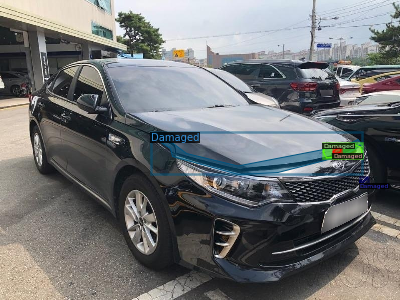

./sampled/jpg/0517974_as-0072150.jpg


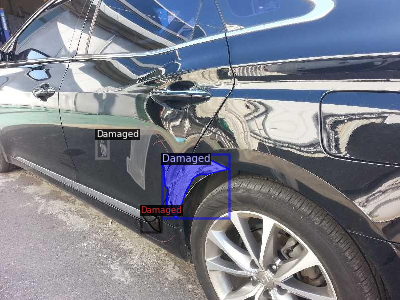

./sampled/jpg/0571544_sc-1040839.jpg


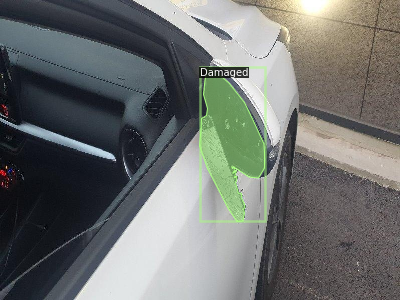

In [ ]:
import random

for d in random.sample(dataset_dicts, 3):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=person_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("Damaged", )
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 600   # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 1 classes (person)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/project_smart/output/model_final.pth" # 여기부분은 본인의 model이저장된 경로로 수정해줍니다.
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("Damaged", )
predictor = DefaultPredictor(cfg)

[03/29 09:48:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/project_smart/output/model_final.pth ...


{'instances': Instances(num_instances=6, image_height=918, image_width=1252, fields=[pred_boxes: Boxes(tensor([[ 221.5156,  253.1468, 1140.4570,  626.5779],
        [ 320.0212,  324.1444,  850.3620,  807.5737],
        [ 226.2875,  443.0282, 1127.3557,  821.0074],
        [ 277.6915,   70.1243,  665.8600,  797.9007],
        [ 164.0484,  151.3339, 1025.1908,  525.8864],
        [ 713.5759,  238.1382, 1111.9440,  853.0251]], device='cuda:0')), scores: tensor([0.7059, 0.7022, 0.6366, 0.6230, 0.6169, 0.5176], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 0, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False

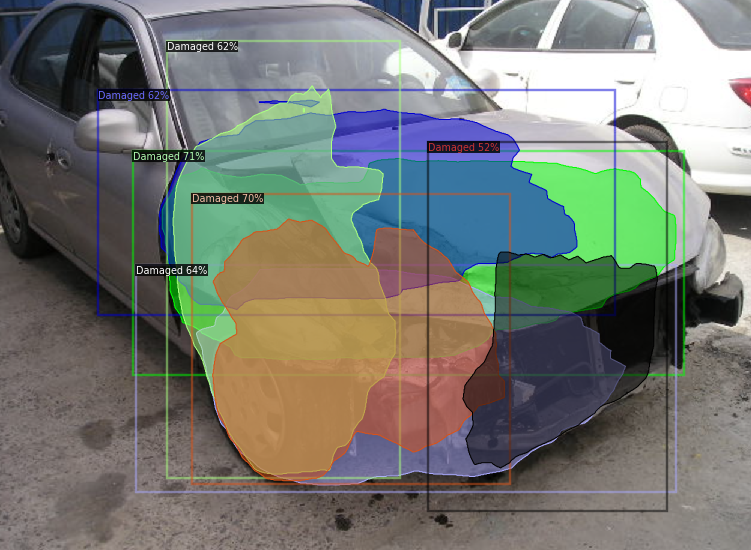

In [ ]:
path = "/content/drive/MyDrive/project_smart/test/nextBently.png"

im = cv2.imread(path)
outputs = predictor(im)
print(outputs)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.6)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])